## solar cycle 25 prediction for the 10.7 cm radio flux (SFU) and sunspot numbers (SSN) 

see these papers for the relationship between SFU and SSN:

Clette 2021:
https://www.swsc-journal.org/articles/swsc/pdf/2021/01/swsc200021.pdf

Tiwari and Kumar
https://journals.aijr.org/index.php/ias/article/view/751/172

We use the Clette 2021 model Equation (2) with a 2nd order polynomial. 

**Issues**
- An error range may be added in the future.


In [7]:
import pickle
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime
from datetime import timedelta
import seaborn as sns
import urllib
import pandas as pd
import os
import sys


#Plotly imports
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
from plotly.offline import iplot, init_notebook_mode
import plotly.express as px
pio.renderers.default = 'browser'


outputdir='results/icme_rate/'

##### check for system type
#server
if sys.platform == 'linux': 
    print('system is linux')
    from config_server import noaa_path
    matplotlib.use('Agg') 
   
        
#mac
if sys.platform =='darwin':  
    print('system is mac')
    from config_local import noaa_path    
    #matplotlib.use('Agg')
    %matplotlib inline     

print(noaa_path)


os.system('jupyter nbconvert --to script solar_cycle_radio_flux.ipynb')    



system is mac
/Users/chris/python/ops/data/noaa/


[NbConvertApp] Converting notebook solar_cycle_radio_flux.ipynb to script
[NbConvertApp] Writing 9514 bytes to solar_cycle_radio_flux.py


0

#### load data from NOAA

In [2]:
#observations
noaa_url='https://services.swpc.noaa.gov/json/solar-cycle/observed-solar-cycle-indices.json'
urllib.request.urlretrieve(noaa_url,noaa_path+'observed-solar-cycle-indices_2024_sep_9.json')

noaa_obs=pd.read_json(noaa_path+'observed-solar-cycle-indices_2024_sep_9.json')

#convert times to matplotlib format
noaa_obs_times=[]

#make datetime objects from file times
for i in np.arange(0,len(noaa_obs)): 
    year=int(noaa_obs['time-tag'][i][0:4])
    month=int(noaa_obs['time-tag'][i][5:7])
    
    noaa_obs_times.append(datetime.datetime(year,month,1))
   
noaa_obs_times_num=mdates.date2num(noaa_obs_times)

SSN_obs=noaa_obs['ssn']
SFU_obs=noaa_obs['f10.7']

#set older SFU values to nan
SFU_obs[:3069]=np.nan

noaa_obs

/var/folders/tr/3wb8vxgd5sj97xz5dz09q0qm0000gn/T/ipykernel_4040/1754360687.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,time-tag,ssn,smoothed_ssn,observed_swpc_ssn,smoothed_swpc_ssn,f10.7,smoothed_f10.7
0,1749-01,96.7,-1.0,-1.00,-1.0,NaN,-1.0
1,1749-02,104.3,-1.0,-1.00,-1.0,NaN,-1.0
2,1749-03,116.7,-1.0,-1.00,-1.0,NaN,-1.0
3,1749-04,92.8,-1.0,-1.00,-1.0,NaN,-1.0
4,1749-05,141.7,-1.0,-1.00,-1.0,NaN,-1.0
...,...,...,...,...,...,...,...
3303,2024-04,136.5,-1.0,141.10,-1.0,161.70,-1.0
3304,2024-05,171.7,-1.0,146.26,-1.0,188.37,-1.0
3305,2024-06,164.2,-1.0,157.10,-1.0,185.06,-1.0
3306,2024-07,196.5,-1.0,190.29,-1.0,198.63,-1.0


#### figure out relationship for SSN to SFU

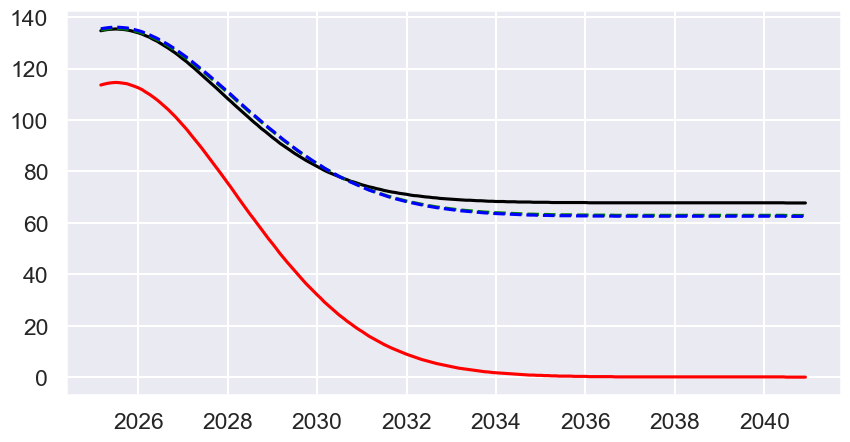

In [3]:
#define models to convert SSN to SFU
def tk_model(SSN_in):
    SFU_out = 62.51 + 0.6422*SSN_in
    return SFU_out

def clette_model(SSN_in):
    SFU_out = 62.87 + 0.6279*SSN_in +6.141*1e-5*SSN_in**2 #equation 2 in Clette 2021 for order 2 polynomial
    return SFU_out


###################### load the NOAA predicted data file 
    
noaa_url='https://services.swpc.noaa.gov/json/solar-cycle/predicted-solar-cycle.json'
urllib.request.urlretrieve(noaa_url,noaa_path+'predicted-solar-cycle.json')
noaa_pred=pd.read_json(noaa_path+'predicted-solar-cycle.json')


#first few datapoints are weird, so I cut them off
noaa_pred=noaa_pred.drop(np.arange(0,12),axis=0)


noaa_pred_times=[]



#make datetime objects from file times
for i in np.arange(12,len(noaa_pred)+12): 
    year=int(noaa_pred['time-tag'][i][0:4])
    month=int(noaa_pred['time-tag'][i][5:7])
    noaa_pred_times.append(datetime.datetime(year,month,1))
    
#noaa_pred

noaa_pred_ssn=noaa_pred['predicted_ssn']
noaa_pred_sfu=noaa_pred['predicted_f10.7']

SFU_pred=np.array(noaa_pred_sfu)
SSN_pred=np.array(noaa_pred_ssn)



#NOAA model
#SFU_NOAA_1=67.00 + 0.4903*SSN < SSN 50
#SFU_NOAA_2=56.06 + 0.7092*SSN > SSN 50

#Johnson 
#SFU_J=60.72 + 0.900*SSN

#Tiwari Kumar 2018 model2
#SFU_TK2=65.6605 + 0.500687*SSN + 1.21647*1e-3*SSN**2- 2.71853*1e-6*SSN**3



sns.set_context('talk')
sns.set_style('darkgrid')
fig=plt.figure(1,figsize=(10,5),dpi=100)

plt.plot(noaa_pred_times,SSN_pred,'r')
plt.plot(noaa_pred_times,SFU_pred,'k')
plt.plot(noaa_pred_times,clette_model(SSN_pred),'g--')
plt.plot(noaa_pred_times,tk_model(SSN_pred),'b--')

### define Hathaway function for SSN from McIntosh+ 2023

In [4]:
def hathaway(x,x0, a, b, c):
    #Hathaway 2015 equation 6 page 40
    #average cycle sunspot number 
    #4 free parameters A, b, c, t0

    x1=(mdates.date2num(x)-mdates.date2num(x0))/30.42
    
    hatfunc=a*(((x1)/b)**3) * 1/(np.exp((((x1)/b)**2))-c)
        
    return hatfunc

#create an array with 1 day resolution between start and end
start_25=datetime.datetime(2020,6,1)
end_25=datetime.datetime(2033,1,1)
times_25_daily = [ start_25 + datetime.timedelta(days=n) for n in range(int ((end_25 - start_25).days))]  

#this sets the solar cycle 25 start time
sc_25_start_time=datetime.datetime(2020,8,1)



#MC 23 model
a=365
aerr68=33 #for 1sigma
b=43.3#60
c=0.71

print('a,b,c:', a,b,c)
print('range for a:',a-aerr68,a+aerr68)


#MC 22 model
#a=363
#aerr68=38 #MC20: 325 -> 170 max, 
#b=60
#c=0.8 
#print('Hathaway function parameters')
#print('a,b,c:', a,b,c)

#create daily SSN prediction 
SSN_mc_prediction=hathaway(times_25_daily, sc_25_start_time,a,b,c)

print('Maximum SSN in McIntosh+ 2023 forecast:', int(np.max(SSN_mc_prediction)))


##make SFU based on SSN prediction

SFU_mc_prediction_1= tk_model(SSN_mc_prediction)
SFU_mc_prediction_2= clette_model(SSN_mc_prediction)

print()
print('maximum SFU based on McIntosh forecast with TK and Clette models')
print(int(np.max(SFU_mc_prediction_1)))
print(int(np.max(SFU_mc_prediction_2)))


a,b,c: 365 43.3 0.71
range for a: 332 398
Maximum SSN in McIntosh+ 2023 forecast: 183

maximum SFU based on McIntosh forecast with TK and Clette models
180
180


/var/folders/tr/3wb8vxgd5sj97xz5dz09q0qm0000gn/T/ipykernel_4040/2849775247.py:68: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



done


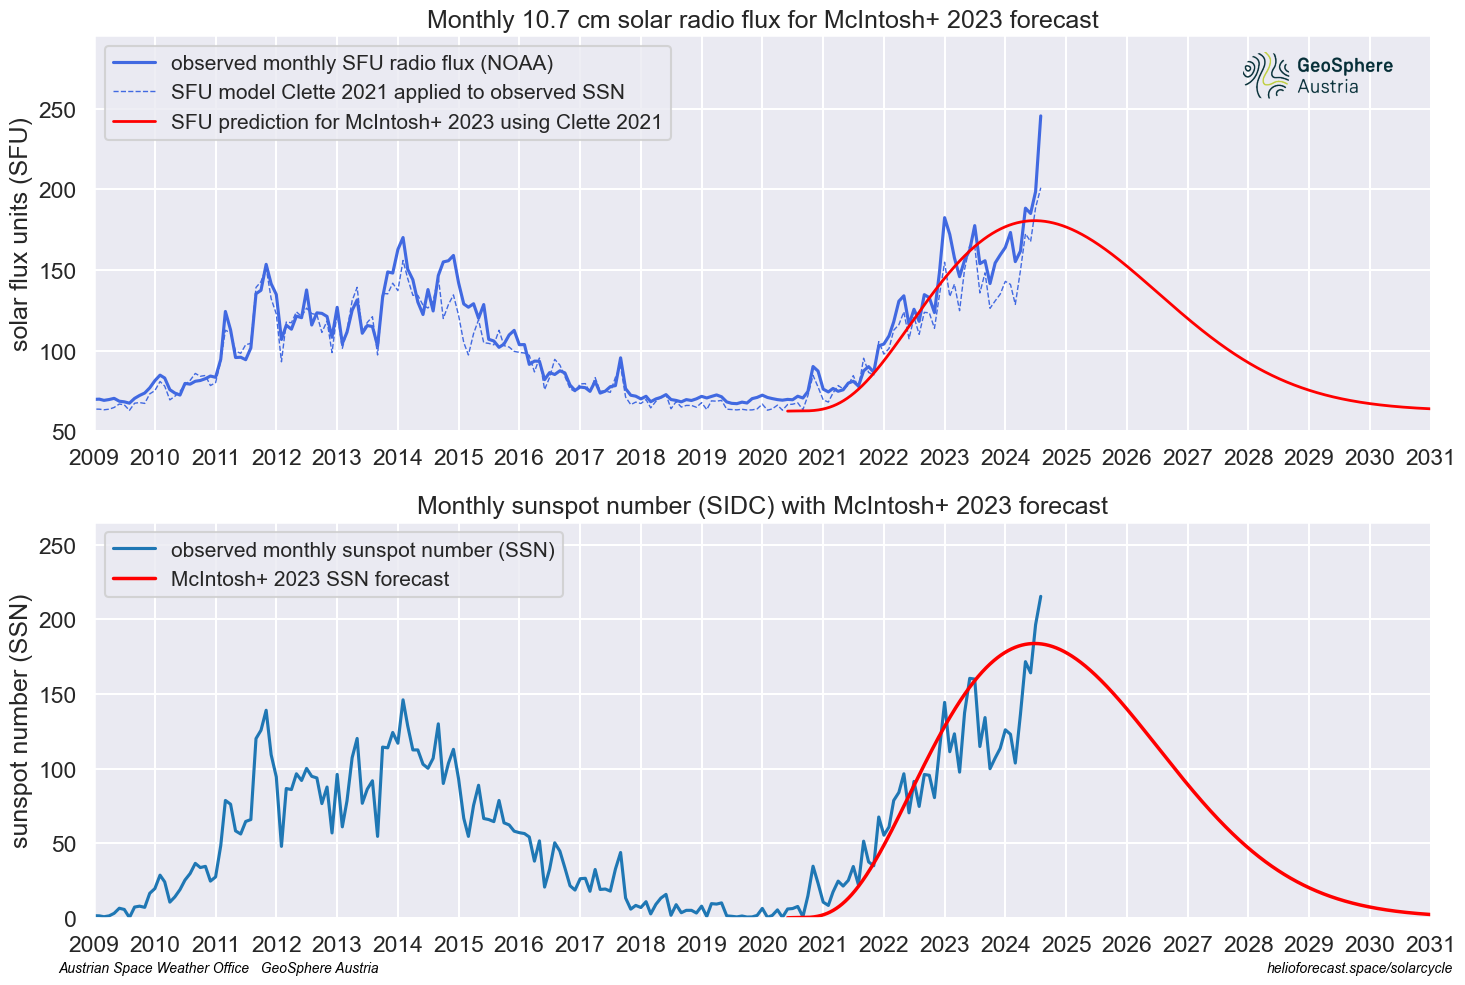

In [5]:
years=np.arange(2005,2040) 
yearly_start_times=[datetime.datetime(year,1,1) for year in years]

sns.set_context('talk')
sns.set_style('darkgrid')

fig1, (ax1, ax2) = plt.subplots(2, figsize=(15,10),dpi=100)

############

ax1.set_title('Monthly 10.7 cm solar radio flux for McIntosh+ 2023 forecast')

ax1.plot(noaa_obs_times,SFU_obs,'-',label='observed monthly SFU radio flux (NOAA)',color='royalblue')
ax1.plot(noaa_obs_times,clette_model(SSN_obs),'--',lw=1,label='SFU model Clette 2021 applied to observed SSN',color='royalblue')
ax1.plot(times_25_daily,SFU_mc_prediction_1,'r-',alpha=1,linewidth=2,label='SFU prediction for McIntosh+ 2023 using Clette 2021')


#ax2.plot(noaa_pred_times,SFU_pred,'b-',lw=2,label='NOAA prediction')
#ax2.plot(times_25_daily,SFU_mc_prediction_2,'k-',alpha=1,linewidth=1,label='TK model for McIntosh/Leamon 2022')
#ax2.plot(noaa_obs_times,tk_model(SSN_obs),'k--',lw=1, label='TK model')


ax1.legend(loc=2,fontsize=15)



#maximum of last 20 years
ax1.set_ylim(50,np.nanmax(SFU_obs[-20*12:])+50)
ax1.set_ylabel('solar flux units (SFU)')

ax1.xaxis_date()
myformat = mdates.DateFormatter('%Y')
ax1.xaxis.set_major_formatter(myformat)
ax1.set_xticks(yearly_start_times, fontsize=12) 
#plt.xlabel('Year',fontsize=12)

ax1.set_xlim(datetime.datetime(2009,1,1),datetime.datetime(2031,1,1))

##################################

ax2.plot_date(noaa_obs_times,SSN_obs,'-', label='observed monthly sunspot number (SSN)')
ax2.plot(times_25_daily,SSN_mc_prediction,'-r',alpha=1,linewidth=2.5,label='McIntosh+ 2023 SSN forecast')

ax2.set_ylabel('sunspot number (SSN)')
#maximum of last 20 years
ax2.set_ylim(0,np.nanmax(SSN_obs[-20*12:]+50))
ax2.legend(loc=2,fontsize=15)
ax2.set_title('Monthly sunspot number (SIDC) with McIntosh+ 2023 forecast')

ax2.xaxis_date()
myformat = mdates.DateFormatter('%Y')
ax2.xaxis.set_major_formatter(myformat)
ax2.set_xticks(yearly_start_times, fontsize=12) 
ax2.set_xlim(datetime.datetime(2009,1,1),datetime.datetime(2031,1,1))


fsize=14   
plt.figtext(0.05,0.01,'Austrian Space Weather Office   GeoSphere Austria', color='black', ha='left',fontsize=fsize-4, style='italic')
plt.figtext(0.98,0.01,'helioforecast.space/solarcycle', color='black', ha='right',fontsize=fsize-4, style='italic')


logo = plt.imread('logo/GSA_Basislogo_Positiv_RGB_XXS.png')
newax = fig1.add_axes([0.84,0.83,0.1,0.1], anchor='NE', zorder=1)
newax.imshow(logo)
newax.axis('off')
    

plt.tight_layout()
plt.savefig(outputdir+'sfu_prediction.png',dpi=100)


print('done')


### plotly interactive plots

In [6]:
nrows=2
fig = make_subplots(rows=nrows, cols=1, shared_xaxes=True,row_heights=[0.4, 0.4],shared_yaxes=False)

######### upper plot
fig.add_trace(go.Scatter(x=noaa_obs_times, y=SFU_obs, name='observed monthly SFU',line_color='royalblue'), row=1, col=1)
fig.add_trace(go.Scatter(x=times_25_daily, y=SFU_mc_prediction_1, name='SFU prediction (McIntosh+ 2023)',line_color='tomato'), row=1, col=1)
fig.add_trace(go.Scatter(x=noaa_obs_times, y=clette_model(SSN_obs), name='Clette SFU from SSN model',line_color='royalblue', line_dash='dot'), row=1, col=1)
fig.update_yaxes(title_text="solar flux units (SFU)", row=1, col=1,range=[0,300])
#fig.update_layout(yaxis=dict(range=[0,200]),row=2,col=1)

#time range
fig.update_layout(xaxis=dict(range=[datetime.datetime.utcnow()-datetime.timedelta(days=365.24*30),datetime.datetime.utcnow()+datetime.timedelta(days=365.24*7)]) )

######### lower plot
fig.add_trace(go.Scatter(x=noaa_obs_times, y=SSN_obs, name='SSN observed',line_color='royalblue'), row=2, col=1)
fig.add_trace(go.Scatter(x=times_25_daily, y=SSN_mc_prediction, name='SSN prediction (McIntosh+ 2023)',line_color='tomato'), row=2, col=1)
fig.update_yaxes(title_text="sunspot number (SSN)", row=2, col=1,range=[0,300])

fig.update_layout(title='Solar flux unit forecast', font=dict(size=20))

#fig.add_annotation(x=0.91, y=1.05, text="East", xref="paper", yref="paper", showarrow=False, font=dict(color='green')  )

fig.write_html(outputdir+'sfu_prediction.html')
print('saved as ',outputdir+'sfu_prediction.html')



saved as  results/icme_rate/sfu_prediction.html
